# Demand Forecasting — Modeling & Evaluation

This notebook focuses on time-aware data splitting, baseline modeling,
and evaluation of forecasting performance.


Import Library

In [27]:
import pandas as pd
import numpy as np

import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pathlib import Path
import json


Load Feature-Engineered Data

In [28]:
DATA_DIR = Path("../data/processed")

train_fe = pd.read_csv(DATA_DIR / "train_fe.csv", parse_dates=["date"])
test_fe  = pd.read_csv(DATA_DIR / "test_fe.csv", parse_dates=["date"])

print(train_fe.shape)
print(test_fe.shape)


(899000, 17)
(500, 17)


Time-based Split

In [29]:
TARGET = "sales"

FEATURES = [
    "store",
    "item",
    "year",
    "month",
    "week",
    "day",
    "dayofweek",
    "is_weekend",
    "lag_7",
    "lag_14",
    "lag_28",
    "rolling_mean_7",
    "rolling_mean_14",
    "rolling_mean_28"
]


In [30]:
split_date = "2017-01-01"

train_df = train_fe[train_fe['date'] < split_date]
valid_df = train_fe[train_fe['date'] >= split_date]

X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_valid = valid_df[FEATURES]
y_valid = valid_df[TARGET]


BASELINE MODEL

Install & Import

In [31]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


Dataset ke LightGBM Format

In [32]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)


Parameter Baseline

In [33]:
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.03,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "seed": 42,
    "verbosity": -1
}


Training

In [34]:
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    num_boost_round=2000,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=50)
    ]
)

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 10.0608	valid's rmse: 11.5076
[100]	train's rmse: 7.81022	valid's rmse: 8.62372
[150]	train's rmse: 7.5414	valid's rmse: 8.23675
[200]	train's rmse: 7.4616	valid's rmse: 8.12107
[250]	train's rmse: 7.42074	valid's rmse: 8.06252
[300]	train's rmse: 7.39409	valid's rmse: 8.02814
[350]	train's rmse: 7.37384	valid's rmse: 8.00428
[400]	train's rmse: 7.35736	valid's rmse: 7.98577
[450]	train's rmse: 7.34308	valid's rmse: 7.97118
[500]	train's rmse: 7.33133	valid's rmse: 7.95924
[550]	train's rmse: 7.32061	valid's rmse: 7.94983
[600]	train's rmse: 7.31134	valid's rmse: 7.94191
[650]	train's rmse: 7.30262	valid's rmse: 7.93555
[700]	train's rmse: 7.29449	valid's rmse: 7.93019
[750]	train's rmse: 7.28717	valid's rmse: 7.92569
[800]	train's rmse: 7.28023	valid's rmse: 7.92251
[850]	train's rmse: 7.27387	valid's rmse: 7.91921
[900]	train's rmse: 7.2679	valid's rmse: 7.91604
[950]	train's rmse: 7.26203	valid's rmse: 7

| Model    | LR   | RMSE      |
| -------- | ---- | --------- |
| baseline | 0.05 | 7.903     |
| tuned    | 0.03 | 7.896     |


In [36]:
best_iter = model.best_iteration
print("Best iteration:", best_iter)

Best iteration: 1907


Feature Importance

In [37]:
import pandas as pd

importance = pd.DataFrame({
    "feature": model.feature_name(),
    "gain": model.feature_importance(importance_type="gain")
})

importance = importance.sort_values("gain", ascending=False)
importance.head(10)


,feature,gain
11,rolling_mean_7,3.236638e+09
8,lag_7,1.601846e+09
12,rolling_mean_14,1.332384e+09
9,lag_14,3.060596e+08
6,dayofweek,2.173615e+08
13,rolling_mean_28,1.508697e+08
10,lag_28,8.319648e+07
3,month,3.970860e+07
4,week,2.780855e+07
5,day,2.533090e+07


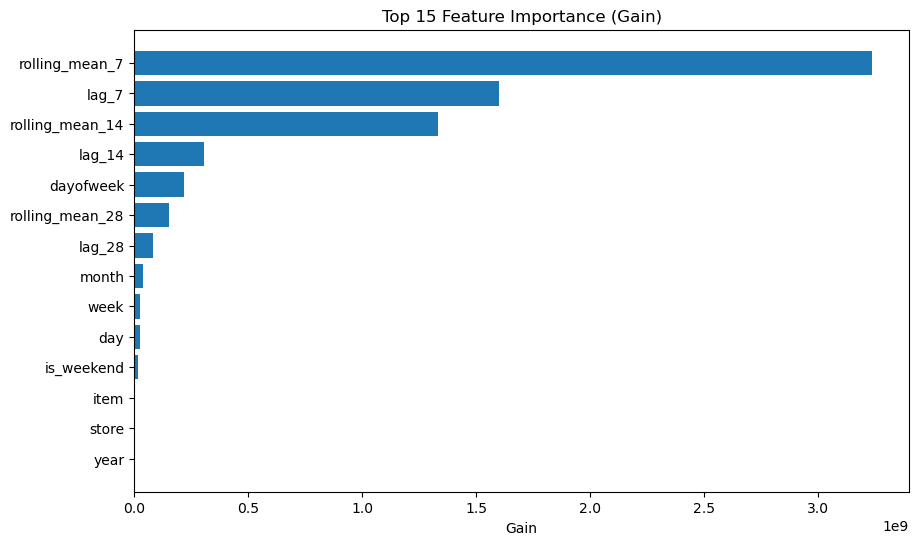

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(
    importance["feature"].head(15)[::-1],
    importance["gain"].head(15)[::-1]
)
plt.title("Top 15 Feature Importance (Gain)")
plt.xlabel("Gain")
plt.show()


In [40]:
importance["split"] = model.feature_importance(importance_type="split")
importance.head(10)


,feature,gain,split
11,rolling_mean_7,3.236638e+09,1525
8,lag_7,1.601846e+09,2413
12,rolling_mean_14,1.332384e+09,971
9,lag_14,3.060596e+08,2404
6,dayofweek,2.173615e+08,3789
13,rolling_mean_28,1.508697e+08,4637
10,lag_28,8.319648e+07,3413
3,month,3.970860e+07,263
4,week,2.780855e+07,6285
5,day,2.533090e+07,5939


“The feature importance analysis based on gain and split metrics shows that rolling mean and lag features—particularly the 7-day and 14-day windows—are the most influential contributors to the model’s predictions. These features not only provide the highest information gain but are also frequently used in tree splits, indicating that short-term historical demand patterns are critical in capturing sales dynamics.

Calendar-related features such as day of the week exhibit a high split count, suggesting they are consistently useful for decision-making across many trees, although their overall contribution (gain) is lower compared to lag-based features. Longer-term features like 28-day rolling means and lags contribute moderately, reflecting the presence of monthly patterns but with less predictive strength.

Time-based features such as week, day, and month show high split frequencies but relatively low gain, implying that they help refine predictions locally rather than drive major reductions in error. Overall, the model relies primarily on recent sales history, with calendar features acting as complementary signals.”

In [41]:
meta = {
    "model": "LightGBM",
    "objective": "regression",
    "metric": "rmse",
    "best_iteration": model.best_iteration,
    "features": FEATURES
}

with open("../models/metadata.json", "w") as f:
    json.dump(meta, f, indent=2)


In [42]:
model = lgb.Booster(model_file="../models/lgb_demand_model.txt")

with open("../models/features.json") as f:
    FEATURES = json.load(f)

print(len(FEATURES), FEATURES)


14 ['store', 'item', 'year', 'month', 'week', 'day', 'dayofweek', 'is_weekend', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7', 'rolling_mean_14', 'rolling_mean_28']
